# MCMC Cosmological Analysis
Converted from MCMC_num.py to Jupyter Notebook format.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import emcee  # Library for implementing the MCMC method
import corner  # Library for plotting figures with contours and pyramids.
from scipy.integrate import simpson
from scipy.integrate import solve_ivp
import pandas as pd

## Extract initial and final $a$, $\delta_\mathrm{cdm}$, and $\delta'_\mathrm{cdm}$ from CLASS output
This cell reads the CLASS transfer function output file, extracts the initial and final values of the scale factor $a$, $\delta_\mathrm{cdm}$, and $\delta'_\mathrm{cdm}$ for the smallest $k$ (largest scale), and prints them for use as initial conditions in ODE integration.

In [ ]:
import pandas as pd

# Path to CLASS output file
path = "/home/pedrorozin/scripts/class_public/output/test_delta_prime_07_perturbations_k0_s.dat"

df = pd.read_csv(
    path,
    comment='#',
    delim_whitespace=True,
    header=None,
    skiprows=1  
)

def set_column_names(df, path):

    with open(path) as f:
        for line in f:
            if line.startswith('#') and ':' in line:
                columns = [col.split(':')[1].strip() for col in line[1:].split('  ') if ':' in col]
                df.columns = columns
                break
    return df

df= set_column_names(df, path)
# print(df.keys())

/tmp/ipykernel_39522/3709003542.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


In [39]:
a = df['a']
delta_cdm = df['delta_cdm']
a_0= a[0]
a_f = a[len(a)-1]
delta_cdm_0 = delta_cdm[0]

In [40]:
# METHODS, DATA AND CONSTANTS
Om_r=5.38*10**(-5)
# a_0=10**(-3)
# a_f=1

def Hh(params,a):
    Om_m_0, s8=params
    Om_L=1-Om_m_0-Om_r
    return np.sqrt(Om_L+Om_m_0/a**3+Om_r/a**4)

def Hh_p(params,a):
    Om_m_0, s8=params
    Om_L = 1-Om_m_0-Om_r
    num = (3*Om_m_0/a**4+4*Om_r/a**5)
    den = 2*np.sqrt(Om_L+Om_m_0/a**3+Om_r/a**4)
    return -num/den

In [41]:
def fs8(params,a): #fs8  
    Om_m_0, s8=params
    a=np.array(a)    
    def F(a,X):
        f1=X[1] 
        term1=X[0]*3*Om_m_0/(2*(Hh(params,a)**2)*(a**5))
        term2=-X[1]*((3/a)+(Hh_p(params,a)/Hh(params,a)))
        f2=term1+term2
        return np.array([f1,f2])
    a_vec=np.linspace(a_0,a_f,2000)
    atol, rtol = 1e-15, 1e-12
    out2 = solve_ivp(fun = F, t_span = [a_0,a_f], y0 = np.array([a_0,1]),
                    t_eval = a_vec, method = 'RK45')
    delta_num=out2.y[0]
    delta_p_num=out2.y[1]
    delta_today=delta_num[-1]
    fs8_teo=[]
    for i in range(len(a)):
        a_val=a[i]
        indice = np.argmin(np.abs(np.array(a_vec) - a_val))
        fs8_teo.append(s8*a[i]*delta_p_num[indice]/delta_today)
    return fs8_teo

In [42]:
def Integrando(params):
    Om_m_0, s8 = params
    return lambda a: 1/((a**2)*Hh(params,a))

def dL(params,a):
    Om_m_0, s8=params    
    x = np.linspace(a, 1, 500)
    y = Integrando((Om_m_0, s8))(x)
    return simpson(y, x)

In [43]:
z = [0.02, 0.02, 0.02, 0.10, 0.15, 0.17, 0.18, 0.38, 0.25, 0.37, 0.32, 0.59, 0.44, 0.60, 0.73, 0.60, 0.86, 1.40]
fs8_data = [0.428, 0.398, 0.314, 0.370, 0.490, 0.510, 0.360, 0.440, 0.3512, 0.4602, 0.384, 0.488, 0.413, 0.390, 0.437, 0.550, 0.400, 0.482]
err = [0.0465, 0.065, 0.048, 0.130, 0.145, 0.060, 0.090, 0.060, 0.0583, 0.0378, 0.095, 0.060, 0.080, 0.063, 0.072, 0.120, 0.110, 0.116]
fid_Om_m=[0.3,0.3,0.266,0.3,0.31,0.3,0.27,0.27,0.25,0.25,0.274,0.307115,0.27,0.27,0.27,0.3,0.3,0.270]
a_prueba=np.array(z)
a_prueba=1/(1+a_prueba)
z_prueba=np.array(z)
# DEFINITION OF THE SCALE FACTOR DATA VECTOR
a=[]
for i in range(len(z)):
    a.append(1/(1+z[i]))
a_data=sorted(a)

In [44]:
def ratio(params):
    Om_m_0,s8=params
    rat=[]
    for i in range(len(a)):
        params_fid=fid_Om_m[i],0.8
        rat.append((Hh(params,a[i])*dL(params,a[i]))/(Hh(params_fid,a[i])*dL(params_fid,a[i])))
    return np.array(rat)

In [7]:
# COVARIANCE MATRIX
sigmas1=[]
for i in range(11):
    sigmas1.append(1/err[i]**2)
sigmas1=np.array(sigmas1)
sigmas2=[]
for i in range(15,18):
    sigmas2.append(1/err[i]**2)
sigmas2=np.array(sigmas2)    
diag_values_1 = sigmas1
non_diag_values = np.linalg.inv(10**(-3)*np.array([[6.400,2.570,0.000],[2.570,3.969,2.540],[0.00,2.540,5.184]]))
diag_values_2 = sigmas2
cov_matrix = np.zeros((18, 18))
np.fill_diagonal(cov_matrix, np.concatenate([diag_values_1, diag_values_2]))
cov_matrix[12:15, 12:15] = non_diag_values

In [45]:
# LIKELIHOOD AND POSTERIOR
def log_likelihood(params, a_data, fs8_data, fs8_err):
    Om_m_0, s8  = params
    fs8_teo=fs8(params,a_data)
    rati=ratio(params)
    V=np.array(fs8_data)-np.array(rati*fs8_teo)
    chi2=V@cov_matrix@V
    loglike = -0.5 * chi2
    return loglike

def log_posterior(params, a_data, fs8_data, fs8_err):
    Om_m_0, s8  = params
    if 0.05 < Om_m_0 < 0.7 and 0.5 < s8 < 1.3 :
        logpost = log_likelihood(params, a_data, fs8_data, fs8_err)
    else:
        logpost = -np.inf
    return logpost

-7.014763715351337


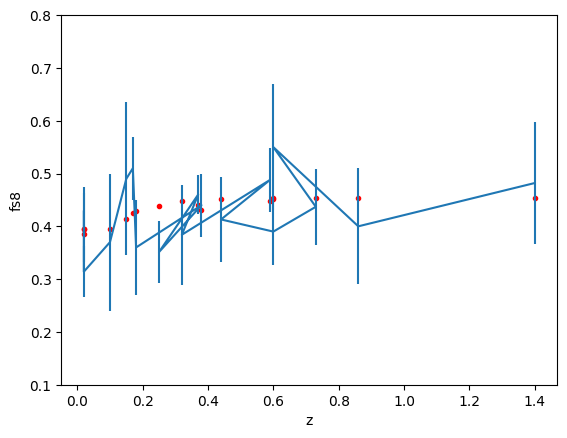

In [46]:
Omegam,sigma8=0.272,0.802
params=Omegam,sigma8
fsigma8_prueba=fs8(params, a)
fsigma8_prueba=sorted(fsigma8_prueba)
like=log_likelihood(params, a_prueba, fs8_data, err)
print(like)

plt.figure()
plt.plot(z_prueba,fsigma8_prueba,'r.')
plt.errorbar(z_prueba,fs8_data,err)
plt.xlabel('z')
plt.ylabel('fs8')
plt.ylim(0.1,0.8)
plt.show()

# Extract and plot $\delta_{cdm}$ vs $a$
The following cell defines a function to return the scale factor array and the corresponding $\delta_{cdm}$ from the ODE integration, and then plots them.

## Extract initial and final $a$, $\delta_\mathrm{cdm}$, and $\delta'_\mathrm{cdm}$ from CLASS output
This cell reads the CLASS transfer function output file, extracts the initial and final values of the scale factor $a$, $\delta_\mathrm{cdm}$, and $\delta'_\mathrm{cdm}$ for the smallest $k$ (largest scale), and prints them for use as initial conditions in ODE integration.

In [33]:
import pandas as pd

# Path to CLASS output file
path = "/home/pedrorozin/scripts/class_public/output/test_delta_prime_07_perturbations_k0_s.dat"

df = pd.read_csv(
    path,
    comment='#',
    delim_whitespace=True,
    header=None,
    skiprows=1  
)

def set_column_names(df, path):

    with open(path) as f:
        for line in f:
            if line.startswith('#') and ':' in line:
                columns = [col.split(':')[1].strip() for col in line[1:].split('  ') if ':' in col]
                df.columns = columns
                break
    return df

df= set_column_names(df, path)
# print(df.keys())

/tmp/ipykernel_39522/3709003542.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


In [23]:
a = df['a']
delta_cdm = df['delta_cdm']
a0= a[0]
af = a[len(a)-1]
delta_cdm_0 = delta_cdm[0]

## ploteo:

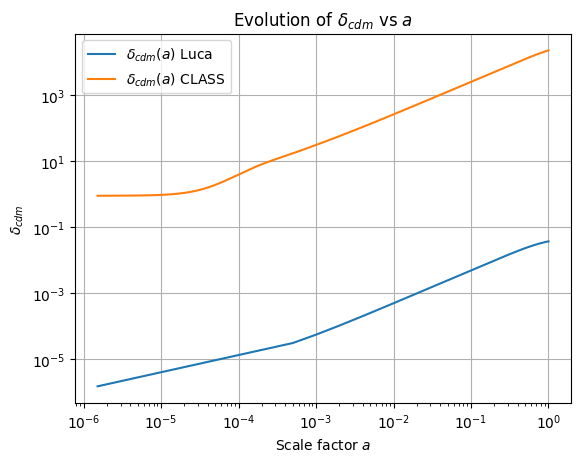

In [47]:
def get_delta_cdm_vs_a(params):
    a_vec = np.linspace(a_0, a_f, 2000)
    def F(a, X):
        f1 = X[1]
        term1 = X[0] * 3 * params[0] / (2 * (Hh(params, a) ** 2) * (a ** 5))
        term2 = -X[1] * ((3 / a) + (Hh_p(params, a) / Hh(params, a)))
        f2 = term1 + term2
        return np.array([f1, f2])
    out2 = solve_ivp(fun=F, t_span=[a_0, a_f], y0=np.array([a_0, 1]),
                     t_eval=a_vec, method='RK45')
    delta_num = out2.y[0]
    return a_vec, delta_num


# params = (a0, delta_cdm_0)  
params=Omegam,sigma8
a_vec, delta_cdm = get_delta_cdm_vs_a(params)

plt.figure()
plt.plot(a_vec, delta_cdm, label=r"$\delta_{cdm}(a)$ Luca")
plt.plot(df['a'], -df['delta_cdm'], label=r"$\delta_{cdm}(a)$ CLASS")
plt.xlabel('Scale factor $a$')
plt.ylabel(r"$\delta_{cdm}$")
# logscale in y and x
plt.yscale('log')
plt.xscale('log')
plt.title(r"Evolution of $\delta_{cdm}$ vs $a$")
plt.legend()
plt.grid(True)
plt.show()

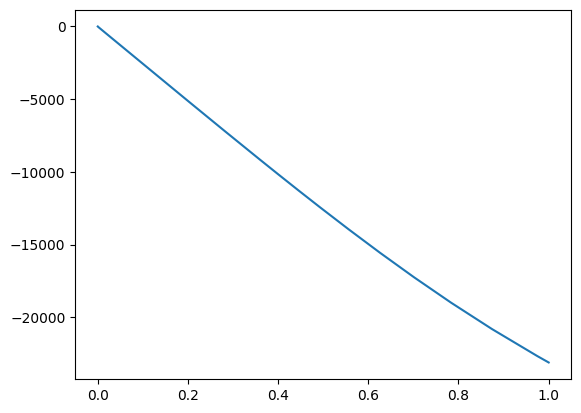

In [30]:
plt.plot(df['a'], df['delta_cdm'], label=r"$\delta_{cdm}(a)$ Luca")

# el resto de luca:

In [ ]:
# MCMC SETUP
ndim     = 2
nwalkers = 10
nsteps   = 10000
init0    = 0.3
init1    = 0.8
p0 = np.array([init0, init1])
p0 = p0 + np.zeros( (nwalkers, ndim) )
p0[:,0] = p0[:,0] + np.random.uniform( low=-0.1, high=0.1, size=nwalkers )
p0[:,1] = p0[:,1] + np.random.uniform( low=-0.1, high=0.1, size=nwalkers )

backend   = emcee.backends.HDFBackend('chain_num.h5')
backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler( nwalkers, ndim, log_posterior, args=(a, fs8_data, err),backend=backend)

max_n = nsteps
index = 0
autocorr = np.empty(max_n)
old_tau = np.inf
for sample in sampler.sample(p0, iterations=max_n, progress=True):
    if sampler.iteration % 100:
        continue
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

In [ ]:
# Save witness file
witness_file = 'witness_num.txt'
textfile_witness = open(witness_file,'w+')
textfile_witness.close()

In [ ]:
# Plot the evolution of the chains
from matplotlib.ticker import MaxNLocator
plt.figure()
fig, ax = plt.subplots( ndim, 1, sharex=True, figsize=(8,9) )
ax0 = ax[0]
ax1 = ax[1]
ax0.plot( sampler.chain[:, :, 0].T, color="k", alpha=0.4 )
ax0.yaxis.set_major_locator(MaxNLocator(5))
ax0.axhline(init0, color="#888888", lw=2)
ax0.set_ylabel("$\Omega_{m0}$")
ax1.plot(sampler.chain[:, :, 1].T, color="k", alpha=0.4)
ax1.yaxis.set_major_locator(MaxNLocator(5))
ax1.axhline(init1, color="#888888", lw=2)
ax1.set_ylabel("$\sigma_8$")
fig.tight_layout()
fig.savefig('chains_num.png')
plt.show()

In [ ]:
# Posterior analysis
samples = sampler.chain[:, :, :].reshape( (-1, ndim) )
post_probs = np.exp( sampler.flatlnprobability - np.max(sampler.flatlnprobability) )
best_fit_params = samples[ np.argmax(post_probs), : ]
print( 'Best fit parameters: Om_m={:.3f}, s_8={:.3f}'.format(*best_fit_params) )
meann_bfit = np.mean(samples, axis=0)
std_bfit   = np.std( samples, axis=0)
fig = corner.corner( samples, labels=[ "$\Omega_{m0}$", "$\sigma_8$"], truths=[init0, init1], \
                              quantiles=[0.16, 0.50], bins=40, plot_datapoints = True, \
                              scale_hist=True )
plt.show()
fig.savefig('triangplot_num.png')
plt.close()

In [ ]:
# Extract and plot delta_cdm (growth factor) vs scale factor a
params = (Omegam, sigma8)
a_vec = np.linspace(a_0, a_f, 2000)

def F(a, X):
    f1 = X[1]
    term1 = X[0] * 3 * Omegam / (2 * (Hh(params, a) ** 2) * (a ** 5))
    term2 = -X[1] * ((3 / a) + (Hh_p(params, a) / Hh(params, a)))
    f2 = term1 + term2
    return np.array([f1, f2])

out2 = solve_ivp(fun=F, t_span=[a_0, a_f], y0=np.array([a_0, 1]),
                 t_eval=a_vec, method='RK45')
delta_num = out2.y[0]

plt.figure(figsize=(7,5))
plt.plot(a_vec, delta_num, label=r"$\delta_{cdm}(a)$")
plt.xlabel('Scale factor $a$')
plt.ylabel(r"$\delta_{cdm}$ (unnormalized)")
plt.title(r"Evolution of $\delta_{cdm}$ vs $a$")
plt.legend()
plt.grid(True)
plt.show()

# Extract initial and final $a$, $\delta_\mathrm{cdm}$, and $\delta'_\mathrm{cdm}$ from CLASS output
This cell reads the CLASS transfer function output file, extracts the initial and final values of the scale factor $a$, $\delta_\mathrm{cdm}$, and $\delta'_\mathrm{cdm}$ for the smallest $k$ (largest scale), and prints them for use as initial conditions in ODE integration.

In [ ]:
import pandas as pd

# Path to CLASS output file
class_output_path = "/home/pedrorozin/scripts/class_public/output/test_delta_prime_03_tk.dat"

# Read CLASS output, skipping comment lines
with open(class_output_path) as f:
    lines = [line for line in f if not line.strip().startswith('#') and line.strip()]

data = [list(map(float, line.split())) for line in lines]
df_class = pd.DataFrame(data)

# Columns: 0=k, 1=d_g, 2=d_b, 3=d_cdm, 4=d_ur, 5=d_prime_cdm, ...
# Select the smallest k (first unique k value)
k0 = df_class[0].unique()[0]
df_k0 = df_class[df_class[0] == k0]

# Initial and final rows for this k
a_initial = df_k0.index[0]
a_final = df_k0.index[-1]
row_initial = df_k0.iloc[0]
row_final = df_k0.iloc[-1]

# Extract values
delta_cdm_initial = row_initial[3]
delta_cdm_prime_initial = row_initial[5]
delta_cdm_final = row_final[3]
delta_cdm_prime_final = row_final[5]

print("Initial conditions (first row for smallest k):")
print(f"k = {k0:.5e}")
print(f"delta_cdm(a0) = {delta_cdm_initial:.5e}")
print(f"delta_cdm'(a0) = {delta_cdm_prime_initial:.5e}")

print("\nFinal conditions (last row for smallest k):")
print(f"delta_cdm(af) = {delta_cdm_final:.5e}")
print(f"delta_cdm'(af) = {delta_cdm_prime_final:.5e}")

Initial conditions (first row for smallest k):
k = 1.35019e-05
delta_cdm(a0) = -1.37584e+00
delta_cdm'(a0) = -9.31769e-05

Final conditions (last row for smallest k):
delta_cdm(af) = -1.37584e+00
delta_cdm'(af) = -9.31769e-05
